## Preprocess Section

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, freqs, sosfilt, periodogram, welch
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# Load right pocket data from subject 1
mat = loadmat('./generated dataset/subject_1_right_pocket.mat')


In [3]:
# The x are the 3 axis recordings ant the t is the time
print(mat['x'].shape)
print(mat['t'].shape)

(63000, 3)
(63000, 1)


In [4]:
# Get the meter of the vector of the 3 axis
acceleration_meter = np.sqrt(mat['x'][:,0]**2 + mat['x'][:,1]**2 + mat['x'][:,2]**2)

In [5]:
def filter_values(values):
    for i in range(len(values)):
        if values[i] > 1000:
            values[i] = values[i-1]
    return values

In [6]:
# Apply high pass butterworth filter of cutoff frequency 1 Hz
def butter_filter(order=5, cutoff=1, type='highpass'):
    # Get the filter coefficients
    # N is the order of the filter
    # Wn is the critical frequency
    # btype is the type of the filter
    # analog=False means that the filter is digital
    # output='sos' should be used for general-purpose filtering.
    # fs is the sampling frequency which is said to be 100 Hz in the assignment
    sos = butter(N=order, Wn=cutoff, btype=type, analog=False, output='sos', fs=100)
    return sos

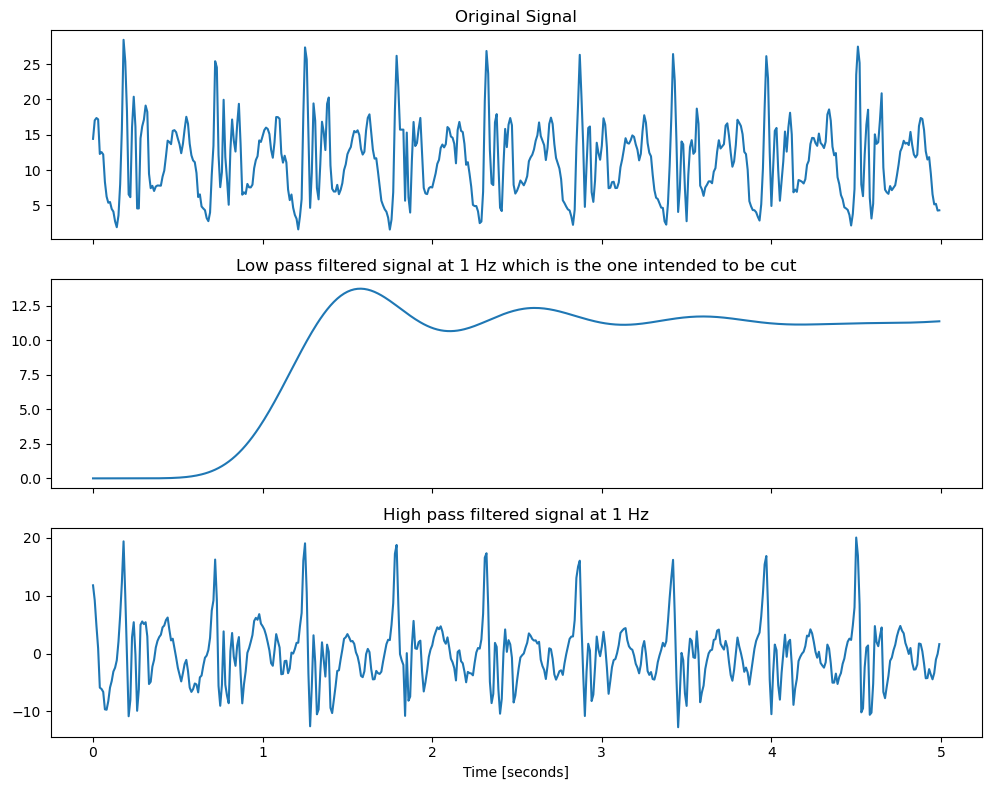

In [7]:
# Plot the 100 first values of signal
n=500

# Set the cutoff frequency
cutt_off_frequency = 1
cutt_off_frequency2 = 1

# Create the figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))

# Plot the original signal
ax1.plot(mat['t'][:n], acceleration_meter[:n])
ax1.set_title('Original Signal')

# Create and apply the lowpass filter
sos = butter_filter(order=10, cutoff=cutt_off_frequency, type='lowpass')
filtered = sosfilt(sos, acceleration_meter[:n])
# Plot the filtered signal
ax2.plot(mat['t'][:n], filtered[:n])
ax2.set_title(f'Low pass filtered signal at {cutt_off_frequency} Hz which is the one intended to be cut')

# Create and apply the highpass filter
sos = butter_filter(order=10, cutoff=cutt_off_frequency2, type='highpass')
filtered = sosfilt(sos, acceleration_meter[:n])

# Plot the filtered signal
ax3.plot(mat['t'][:n], filtered[:n])
ax3.set_title(f'High pass filtered signal at {cutt_off_frequency2} Hz')
ax3.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [8]:
def load_and_process_signal(path, target_path, cutt_off_frequency=1, step=100):
    # load data
    data = loadmat(path)

    # convert x,y,z to a one meter of vector
    acc_meter = np.sqrt(data['x'][:,0]**2 + data['x'][:,1]**2 + data['x'][:,2]**2)

    # filter values
    acc_meter = filter_values(acc_meter)
    # Create and apply the highpass filter
    filter = butter_filter(order=10, cutoff=cutt_off_frequency, type='highpass')
    filtered_signal = sosfilt(filter, acc_meter)

    # split signal into smaller ones of one second duration 
    fraction_signals = []
    # iterate over the signal with a step of 100 because the sampling frequency is 100 Hz so 100 samples in one second
    for i in range(0, len(filtered_signal), step):
        # Get the fraction signal
        fraction_signals.append(filtered_signal[i:i+step])
    # Initialize the features array
    features_array = []
    for signal in fraction_signals:
        # Calculate the power spectrum of the signal with the welch method
        f, Pxx = welch(signal, fs=200, return_onesided=True, scaling='spectrum', average='median', nfft=2**11, nperseg=step);
        # Initialize the features list
        features = []
        for fracture in range(0,10):
            # Calculate the lower and upper bound of the power spectrum
            lower = 2**fracture
            upper = 2**(fracture+1)
            # Get the power spectrum of the signal from fracture to fracture+1
            power = Pxx[lower:upper]
            # Append the sum of the power spectrum to the features list
            features.append(power.sum())
        # Append the features to the features array
        features_array.append(features)
    return fraction_signals, features_array

In [25]:
# Settings to load the data
get_only_right_pocket = False
# Set the step to samples
step = 200


subjects = ['subject_1', 'subject_2', 'subject_3', 'subject_4', 'subject_5', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10']
if get_only_right_pocket:
    positions = ['right_pocket']
else:
    positions = ['right_pocket', 'left_pocket', 'upper_arm', 'belt', 'wrist']

fraction_signals = []
human_data = []
human_targets = []
for subject in subjects:
    # Load the ground truth for the specified human
    ground_truth = loadmat(f'./generated dataset/{subject}_ground_truth.mat')
    # Initialize the target list
    target = []
    # Extract the target from the ground truth because it is saved in matlab format
    for i in range(0, len(ground_truth['label'])):
        target.append(ground_truth['label'][i][0][0])
    labels = []
    # iterate over the signal with a step of 100 because the sampling frequency is 100 Hz so 100 samples in one second
    for i in range(0, 63000, step):
        # Get the label with the highest count in the 100 samples for activity
        labels.append(pd.DataFrame(target[i:i+100]).value_counts().keys()[0][0])
    human_targets.append(labels)

    # Get data from each position
    for position in positions:
        fraction_signal, features_array = load_and_process_signal(f'./generated dataset/{subject}_{position}.mat', f'./generated dataset/{subject}_{position}.mat', cutt_off_frequency=1, step=step)
        fraction_signals.append(fraction_signal)
        human_data.append(features_array)

In [26]:
# Standardize the data
human_data = np.array(human_data)
human_targets = np.array(human_targets)
fraction_signals = np.array(fraction_signals)

means = []
stds = []
# Calculate the mean and standard deviation of each feature from all humans and all positions
for i in range(10):
    means.append(human_data[:,:,i].mean())
    stds.append(human_data[:,:,i].std())
# Standardize the data as said in the assignment
for i in range(10):
    human_data[:,:,i] = (human_data[:,:,i] - means[i]) / stds[i]

In [27]:
# There is a problem in the data so we need to replace the words upsatirs with upstairs
print(np.unique(human_targets))
human_targets = np.where(human_targets == 'upsatirs', 'upstairs', human_targets)
print(np.unique(human_targets))

['biking' 'downstairs' 'jogging' 'sitting' 'standing' 'upsatirs'
 'upstairs' 'walking']
['biking' 'downstairs' 'jogging' 'sitting' 'standing' 'upstairs' 'walking']


In [28]:
print('The shape of human data is:      ', human_data.shape)
print('The shape of human targets is:   ', human_targets.shape)
print('The shape of fraction signals is:', fraction_signals.shape)

The shape of human data is:       (50, 315, 10)
The shape of human targets is:    (10, 315)
The shape of fraction signals is: (50, 315, 200)


## Train SVM classifier

Accuracy for subject out 1: 74.29%
Accuracy for subject out 2: 76.51%
Accuracy for subject out 3: 62.22%
Accuracy for subject out 4: 61.59%
Accuracy for subject out 5: 63.81%
Accuracy for subject out 6: 79.37%
Accuracy for subject out 7: 77.78%
Accuracy for subject out 8: 54.60%
Accuracy for subject out 9: 65.71%
Accuracy for subject out 10: 43.49%


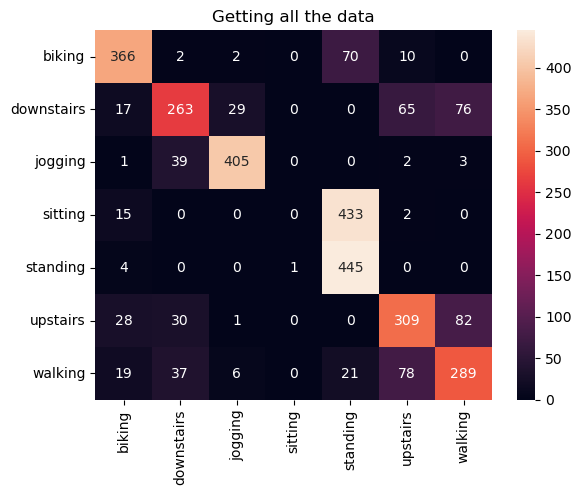

In [29]:
# Perform one subject out cross validation
total_confusion_matrix = np.zeros((7,7))
for subject in range(10):
    # Initialize the test and train data and targets
    test_data = []
    test_targets = []
    train_data = []
    train_targets = []
    # Iterate over the subjects
    for i in range(10):
        # If the subject is the one that is left out
        if i == subject:
            # Append the data and targets to the test data and targets
            test_data = human_data[i]
            test_targets = human_targets[i]
        else:
            # Append the data and targets to the train data and targets
            train_data.append(human_data[i])
            train_targets.append(human_targets[i])
    # Convert the train data and targets to numpy arrays
    train_data = np.array(train_data)
    train_targets = np.array(train_targets)
    # Use SVM as classifier with rbf kernel and gamma=1/p and C=1 where p the dimension of the features
    clf = SVC(kernel='rbf', gamma=1/10, C=1)
    # Flatten the train data and targets
    train_data = train_data.reshape(-1, 10)
    train_targets = train_targets.reshape(-1)
    # Fit the SVM classifier
    clf.fit(train_data, train_targets)
    # Flatten the test data
    test_data = test_data.reshape(-1, 10)
    # Predict the test data
    predictions = clf.predict(test_data)
    # Print the accuracy
    print(f'Accuracy for subject out {subject+1}: {accuracy_score(test_targets, predictions)*100:.2f}%')
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(test_targets, predictions)
    # Add the confusion matrix to the total confusion matrix
    total_confusion_matrix += conf_matrix
# Plot the confusion matrix
ax = plt.axes()
sns.heatmap(total_confusion_matrix, annot=True, fmt='g', xticklabels=['biking', 'downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking'], yticklabels=['biking', 'downstairs', 'jogging', 'sitting', 'standing', 'upstairs', 'walking']);
if get_only_right_pocket:
    ax.set_title('Confusion matrix for data only from the right pocket')
else:
    ax.set_title('Getting all the data')
plt.show()

With only the right pocket data:
```
Accuracy for subject out 1: 69.05%
Accuracy for subject out 2: 73.33%
Accuracy for subject out 3: 72.38%
Accuracy for subject out 4: 79.37%
Accuracy for subject out 5: 77.46%
Accuracy for subject out 6: 79.68%
Accuracy for subject out 7: 78.57%
Accuracy for subject out 8: 63.81%
Accuracy for subject out 9: 70.79%
Accuracy for subject out 10: 67.30%
```

Gettinga all the positions:
```
Accuracy for subject out 1: 70.00%
Accuracy for subject out 2: 76.51%
Accuracy for subject out 3: 58.25%
Accuracy for subject out 4: 59.52%
Accuracy for subject out 5: 59.52%
Accuracy for subject out 6: 79.21%
Accuracy for subject out 7: 74.29%
Accuracy for subject out 8: 45.40%
Accuracy for subject out 9: 63.17%
Accuracy for subject out 10: 38.41%
```